# Data Science Essentials: GeoPandas
    Everett
    Bergeson
    9/28/2021

In [32]:
! pip install geopandas
from google.colab import files
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib import animation
%matplotlib inline

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


## Problem 1

Read in the file *airports.csv* as a pandas dataframe.
Create three convex hulls around the three sets of airports listed below.
This can be done by passing in lists of the airports' coordinates to a *shapely.geometry.Polygon* object.

1. Maio Airport, Scatsta Airport, Stokmarknes Skagen Airport, Bekily Airport, K. D. Matanzima Airport, RAF Ascension Island
2. Oiapoque Airport, Maio Airport, Zhezkazgan Airport, Walton Airport, RAF Ascension Island, Usiminas Airport, Piloto Osvaldo Marques Dias Airport
3. Zhezkazgan Airport, Khanty Mansiysk Airport, Novy Urengoy Airport, Kalay Airport, Biju Patnaik Airport, Walton Airport
	
Create a new GeoDataFrame with these three Polygons as entries.
Plot this GeoDataFrame on top of an outlined world map.

In [ ]:
# upload airport.csv
airport = files.upload()

Saving airports.csv to airports.csv


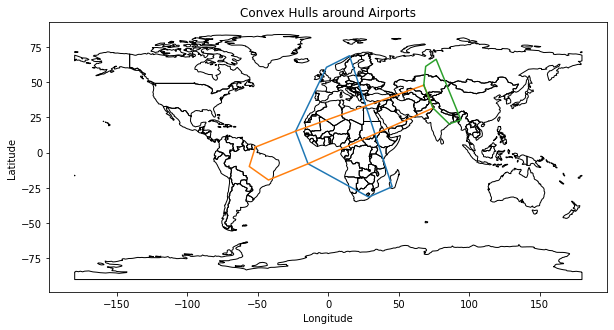

In [38]:
first_set = ['Maio Airport', 'Scatsta Airport', 'Stokmarknes Skagen Airport',
                 'Bekily Airport','K. D. Matanzima Airport', 'RAF Ascension Island']
second_set = ['Oiapoque Airport','Maio Airport', 'Zhezkazgan Airport',
                'Walton Airport','RAF Ascension Island','Usiminas Airport',
                 'Piloto Osvaldo Marques Dias Airport']
third_set = ['Zhezkazgan Airport','Khanty Mansiysk Airport','Novy Urengoy Airport',
                 'Kalay Airport','Biju Patnaik Airport','Walton Airport']


# Set outline of world countries as base
fig,ax = plt.subplots(figsize=(10,7), ncols=1, nrows=1)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.boundary.plot(edgecolor='black', ax=ax, linewidth=1)

# Load airport data and convert to a GeoDataFrame
airports = pd.read_csv('airports.csv')

# For each set create a new dataframe
sets = [first_set, second_set, third_set]
for _set in sets:
    dict_list = []
    for ap in _set:
        dict_list.append(dict({"Name" : ap, 
                               "Latitude":airports['Latitude'][airports['Name']==ap].values,
                               "Longitude":airports['Longitude'][airports['Name']==ap].values}))
    df1 = pd.DataFrame(dict_list)    
    polygon1 = Polygon(list(zip(df1.Longitude, df1.Latitude)))
    plt.plot(*polygon1.exterior.xy)

# Plot airports on top of world map
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Convex Hulls around Airports')

plt.show()

## Problem 2
Use the command *geopandas.read_file('county_data.gpkg')* to create a GeoDataFrame of information about US counties.
Each county's shape is stored in the *geometry* column.
Use this to **plot the outlines of all US counties two times**, first using the default CRS and then using EPSG:5071.

Next, create a new GeoDataFrame that combines all counties within a single state.
Drop states with the following STATEFP codes: 02, 15, 60, 66, 69, 72, 78.
Plot this GeoDataFrame to see an outline of the 48 contiguous states.
Ensure a CRS of 5071.

In [ ]:
# upload county.gpkg.zip
county = files.upload()
!unzip county_data.gpkg.zip
county_df = gpd.read_file('county_data.gpkg')

Saving county_data.gpkg.zip to county_data.gpkg.zip
Archive:  county_data.gpkg.zip
   creating: county_data.gpkg/
 extracting: county_data.gpkg/county_data.cpg  
  inflating: county_data.gpkg/county_data.dbf  
  inflating: county_data.gpkg/county_data.prj  
  inflating: county_data.gpkg/county_data.shp  
  inflating: county_data.gpkg/county_data.shx  


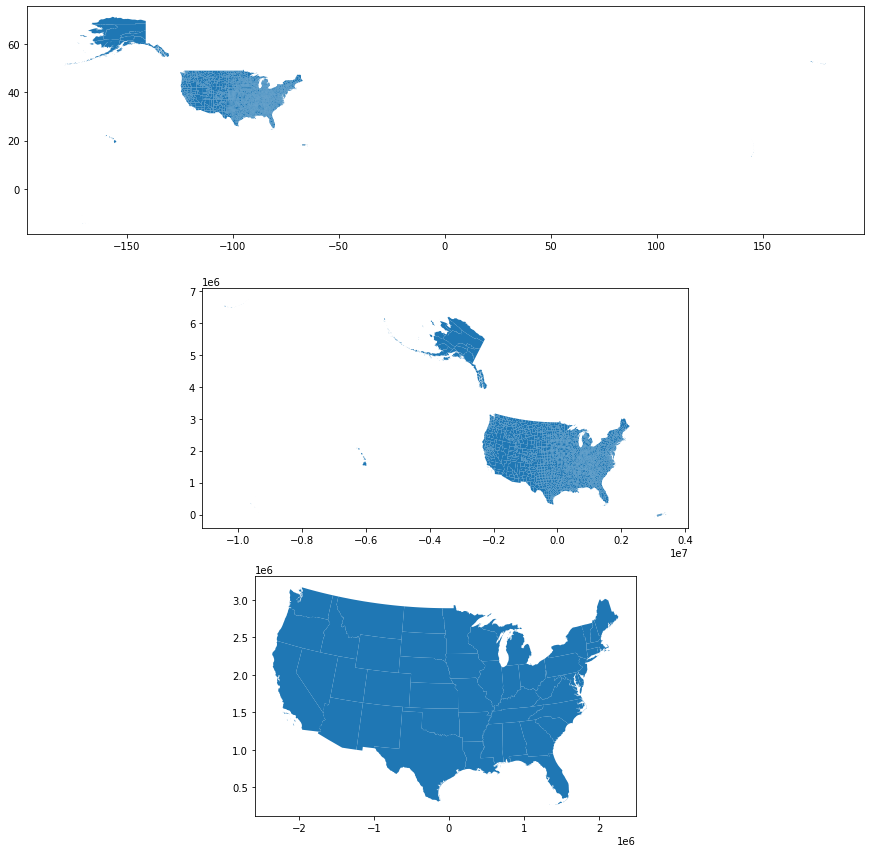

In [33]:
fig, ax = plt.subplots(3, figsize=(15,15))
df = gpd.read_file('county_data.gpkg')
df.plot(ax=ax[0])

df.to_crs(5071, inplace=True)
df.plot(ax=ax[1])

df = df.set_index('STATEFP')
df = df.drop(['02', '15', '60', '66', '69', '72', '78'])
df = df.reset_index()
state_df = df.dissolve(by = 'STATEFP', as_index=True)
state_df = state_df.reset_index()
state_df.plot(ax=ax[2])
plt.show()

## Problem 3

Load in the file *nytimes.csv* as a DataFrame.
This file includes county-level data for the cumulative cases and deaths of Covid-19 in the US, starting with the first case in Snohomish County, Washington, on January 21, 2020.
**First, convert the *date* column into a *DatetimeIndex*.**

Next, use county FIPS codes to **merge your GeoDataFrame from the previous problem with the DataFrame you just created.**
A FIPS code is a 5-digit unique identifier for geographic locations.
For this lab, we will ignore rows in the Covid-19 DataFrame with unknown FIPS codes.
Also, we will just be examining data from the contiguous US, so **drop all data from Hawaii and Alaska.**

Note that the *fips* column of the Covid-19 DataFrame stores entries as floats, but the county GeoDataFrame stores FIPS codes as strings, with the first two digits in the *STATEFP* column and the last three in the *COUNTYFP* column.

**Plot the cases from March 21, 2020 on top of your state outline map from the previous problem.
Finally, print out the name of the county with the most cases along with its case count.**

In [ ]:
# upload airport.csv
nytimes = files.upload()

Saving nytimes.csv to nytimes.csv


Index(['Unnamed: 0', 'date', 'county', 'state', 'fips', 'cases', 'deaths',
       'date_time'],
      dtype='object')
258027
3108
254208
<class 'pandas.core.frame.DataFrame'>
1015


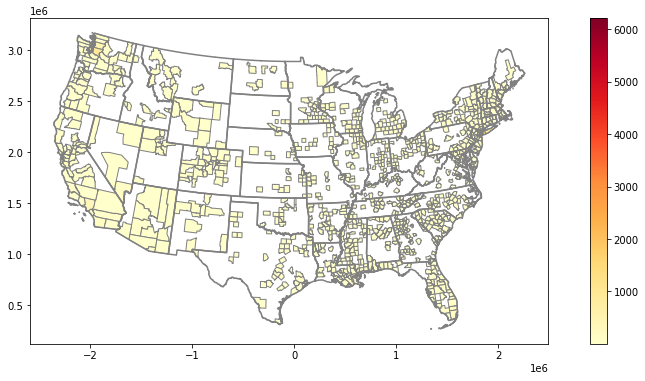

In [ ]:
fig, ax = plt.subplots(figsize=(15,6), ncols=1, nrows=1)
base = state_df.boundary.plot(ax=ax, color='gray')
# Load NY Times File, add datetime
ny_df = pd.read_csv('nytimes.csv')
ny_df['date_time'] = pd.to_datetime(ny_df['date'])
ny_df['fips'] = ny_df['fips'].astype(float)
#ny_df.to_crs(5071, inplace=True)
print(ny_df.columns)
print(len(ny_df))

# Load county files, drop non-contiguous states
county_df = gpd.read_file('county_data.gpkg')
county_df = county_df.set_index('STATEFP')
county_df = county_df.drop(['02', '15', '60', '66', '69', '72', '78'])
county_df = county_df.reset_index()
county_df['fips'] = county_df['STATEFP'] + county_df['COUNTYFP']
county_df['fips'] = county_df['fips'].astype(float)
county_df.to_crs(5071, inplace=True)
print(len(county_df))

merged = pd.merge(ny_df, county_df, on='fips')
print(len(merged))
merged = merged[merged['date_time'].notna()]

march_df = merged[merged['date_time'].dt.month == 3]
march_21_df = march_df[march_df['date_time'].dt.day == 21]


print(type(march_21_df))
march_21_df = gpd.GeoDataFrame(march_21_df)
print(len(march_21_df))
march_21_df.plot(column='cases', cmap='YlOrRd', legend=True, ax=ax, edgecolor='gray')
plt.show()

## Problem 4

As in Problem 3, plot your state outline map together with a map of Covid-19 cases from March 21, 2020.
This time, use a log scale.
Use EPSG:5071.
Pick a good colormap and be sure to display a colorbar.

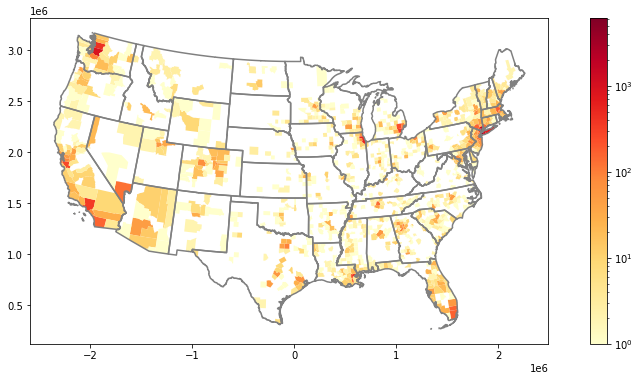

In [ ]:
fig, ax = plt.subplots(figsize=(15,6), ncols=1, nrows=1)
base = state_df.boundary.plot(ax=ax, color='gray')

# Set the norm using data bounds
data = march_21_df.cases
norm = LogNorm(vmin=min(data), vmax=max(data))
# Plot the graph using the norm
march_21_df.plot(column='cases', cmap='YlOrRd', legend=True, ax=ax, norm=norm)

plt.show()


## Problem 5
In this problem, you will create an animation of the spread of Covid-19 through US counties from January 21, 2020 to June 21, 2020.
Use a log scale and a good colormap, and be sure that you're using the same norm and colorbar for the whole animation.
Use EPSG:5071 for the CRS.

As a reminder, below is a summary of what you will need in order to animate this map.
You may also find it helpful to refer to the animation section included with the Volume 4 lab manual. 

- Set up your figure and norm. Be sure to use the highest case count for your vmax so that the scale remains uniform.
- Write your update function. This should plot the cases from a given day.
- Set up your colorbar. Do this outside the update function to avoid adding a new colorbar each day.
- Create the animation. Check to make sure everything displays properly before you save it.
- Save the animation.
- Display the animation.

In [ ]:
pd.date_range("2020-01-21", periods=153, freq="D")

DatetimeIndex(['2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30',
               ...
               '2020-06-12', '2020-06-13', '2020-06-14', '2020-06-15',
               '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
               '2020-06-20', '2020-06-21'],
              dtype='datetime64[ns]', length=153, freq='D')

Index(['Unnamed: 0', 'date', 'county', 'state', 'fips', 'cases', 'deaths',
       'date_time'],
      dtype='object')
258027
3108


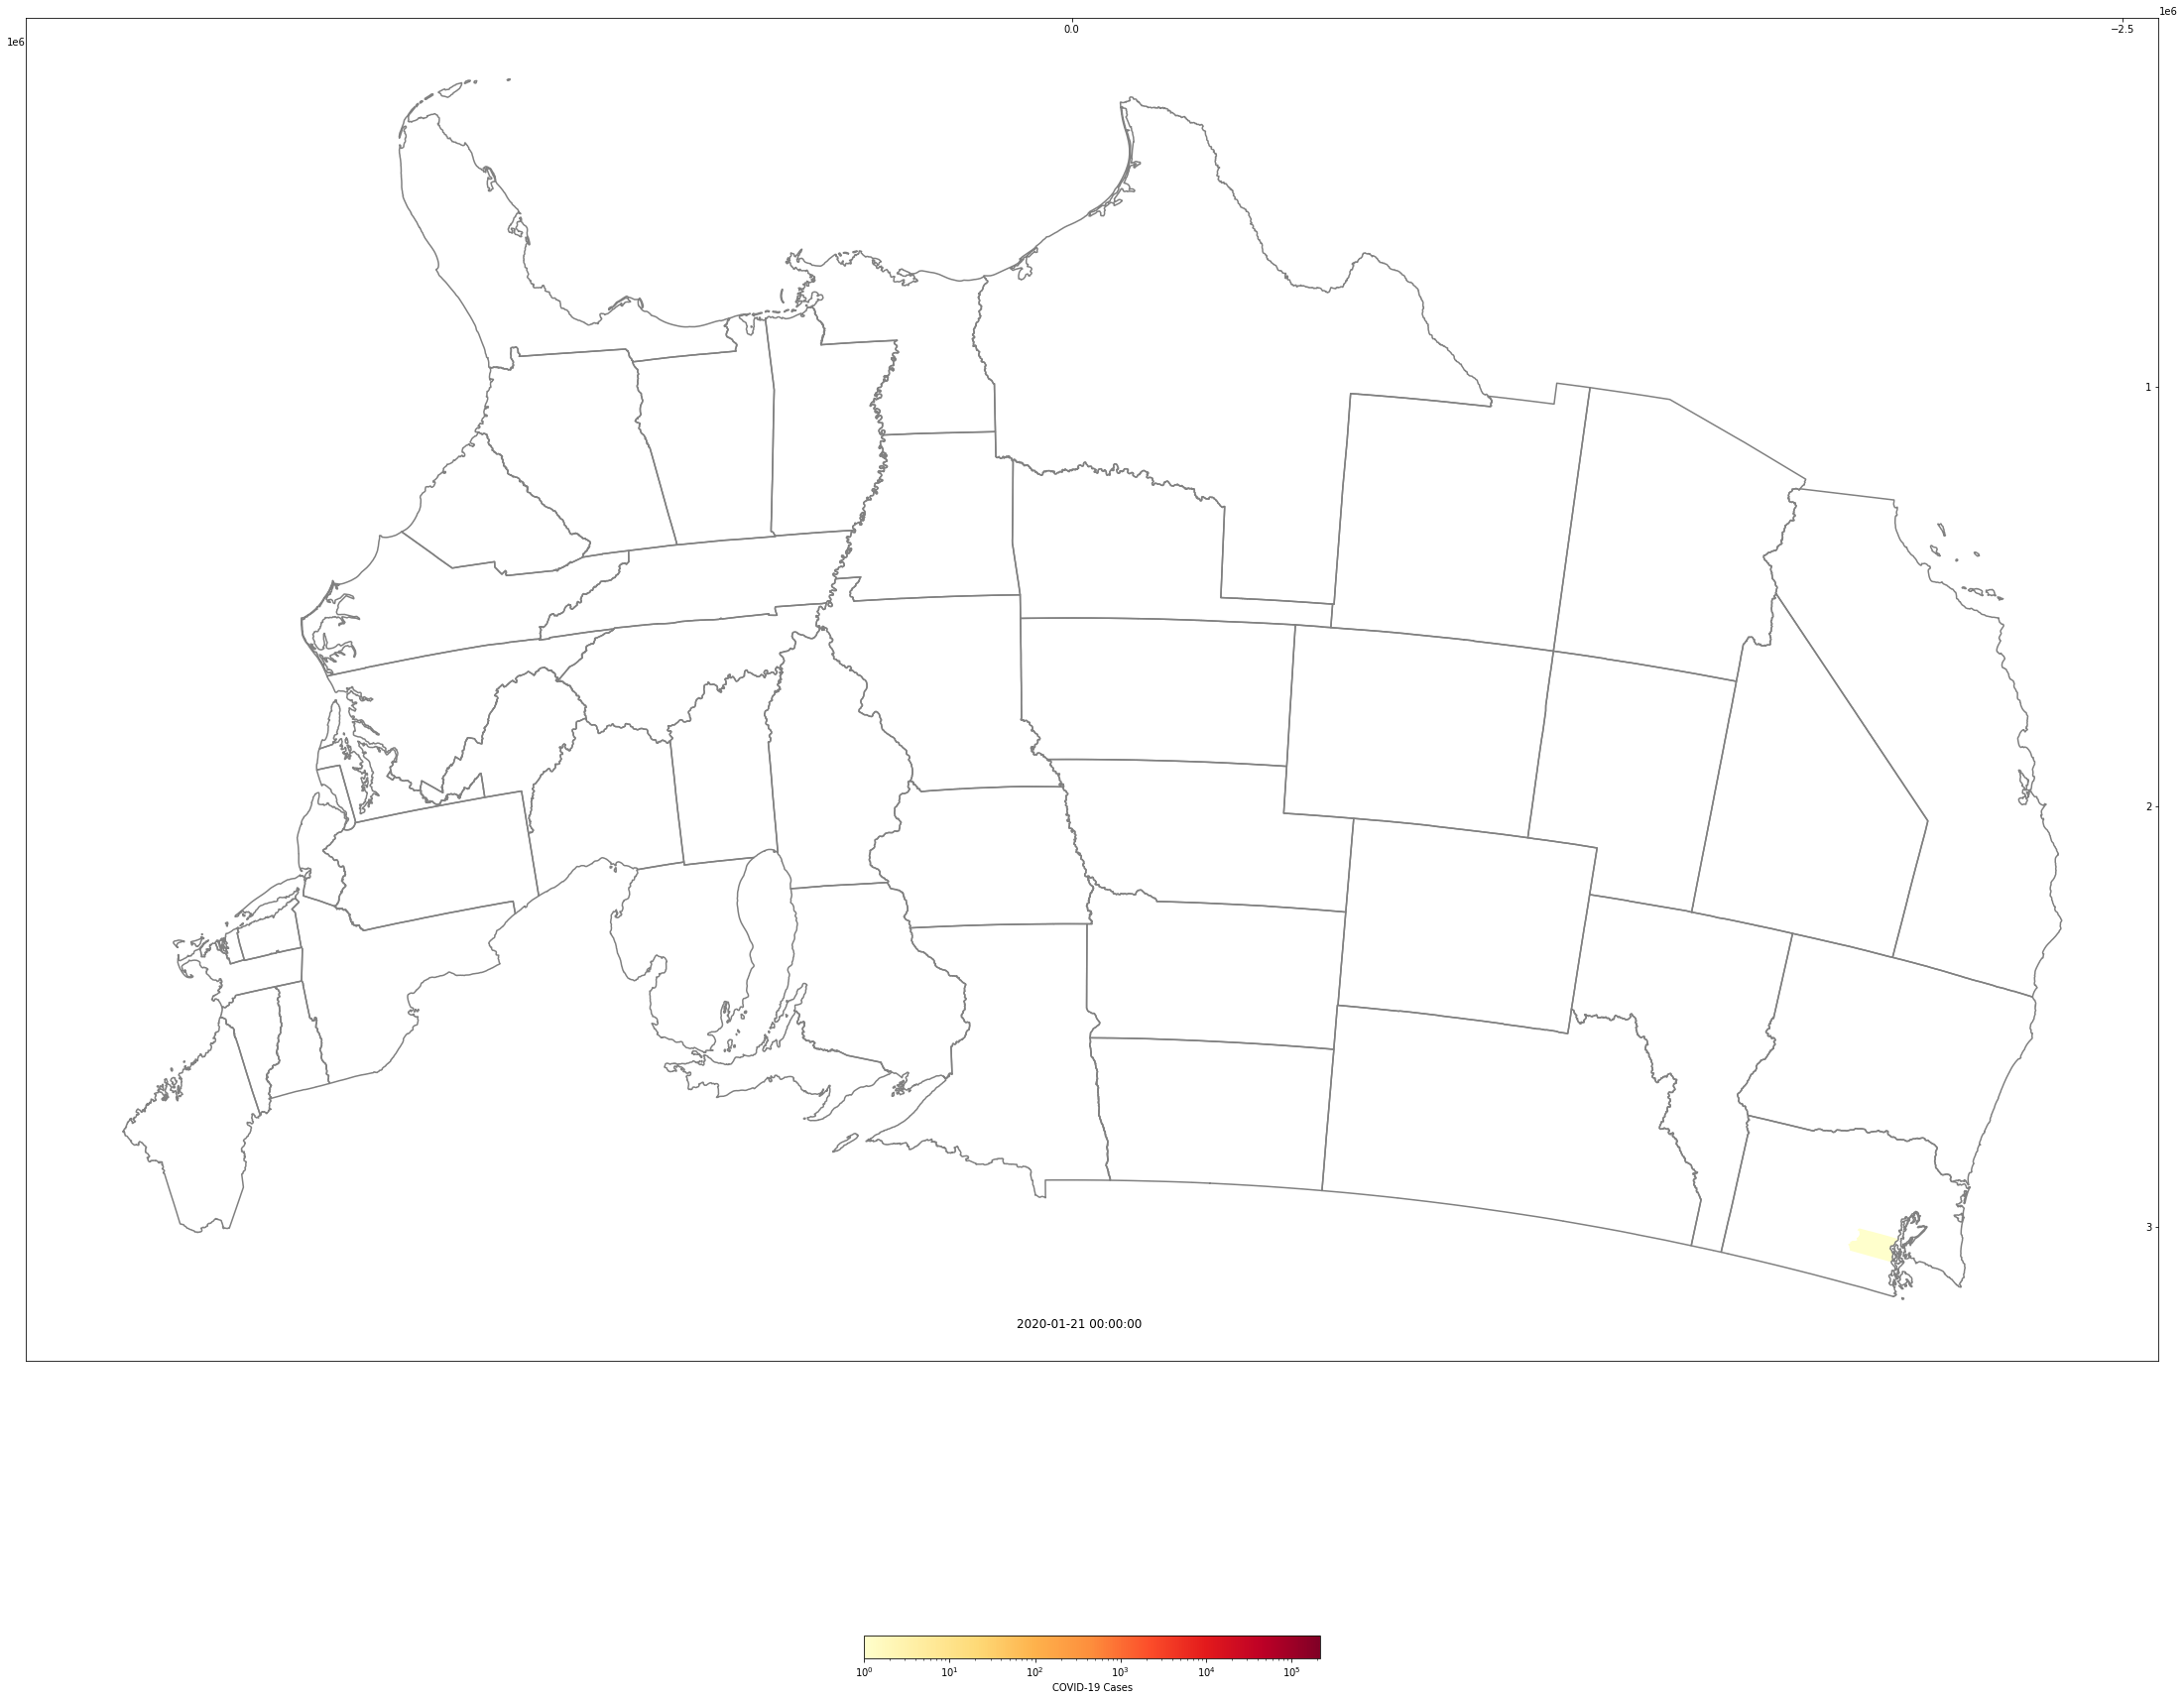

<Figure size 432x288 with 0 Axes>

In [36]:
#Set up figure and norm
fig, ax = plt.subplots(figsize=(15,6), ncols=1, nrows=1)
base = state_df.boundary.plot(ax=ax, color='gray')

# Load NY Times File, add datetime
ny_df = pd.read_csv('nytimes.csv')
ny_df['date_time'] = pd.to_datetime(ny_df['date'])
ny_df['fips'] = ny_df['fips'].astype(float)
#ny_df.to_crs(5071, inplace=True)
print(ny_df.columns)
print(len(ny_df))

# Load county files, drop non-contiguous states
county_df = gpd.read_file('county_data.gpkg')
county_df = county_df.set_index('STATEFP')
county_df = county_df.drop(['02', '15', '60', '66', '69', '72', '78'])
county_df = county_df.reset_index()
county_df['fips'] = county_df['STATEFP'] + county_df['COUNTYFP']
county_df['fips'] = county_df['fips'].astype(float)
county_df.to_crs(5071, inplace=True)
print(len(county_df))

# Merge and clean datasets
merged = pd.merge(ny_df, county_df, on='fips')
merged = merged[merged['date_time'].notna()]

# Set up norm
data = merged.cases
norm = LogNorm(vmin=min(data), vmax=max(data))


# Create update function
def update(date):
    #Plot the cases from a single day
    plt.suptitle(date) #.dt.strftime("%m/%d/%y"))
    current_day = gpd.GeoDataFrame(merged[merged['date_time'] == date])
    current_day.plot(column='cases', cmap='YlOrRd', ax=ax, norm=norm)
    
ani = animation.FuncAnimation(fig, update, frames=pd.date_range("2020-01-21", periods=153, freq="D"), interval=25)

plt.show() 
#Set up the colorbar
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='YlOrRd'), 
                    ax=ax, orientation='horizontal', pad=5, 
                    label='COVID-19 Cases', shrink=.55)

#Create the animation
ani.save('covid_ani_slow.gif', writer='pillow', fps=8)


CalledProcessError: ignored

<Figure size 432x288 with 0 Axes>

<video src='your_video_name.mp4' controls width=800>